In [35]:
import pandas as pd
import numpy as np
import sqlite3
import requests
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set(rc={'figure.figsize':(20, 5)})

In [188]:
def geocoder_district(lon, lat, key):
    url = 'https://geocode-maps.yandex.ru/1.x'
    
    params = {'format':'json', 'apikey': key, 'geocode': str(lon) + ',' + str(lat), 'kind':'district'}
    response = requests.get(url, params=params)
    
    # Округ
    district = response.json()["response"]["GeoObjectCollection"]["featureMember"][0]["GeoObject"] \
        ["metaDataProperty"]["GeocoderMetaData"]["AddressDetails"]["Country"]["AdministrativeArea"] \
        ["Locality"]["DependentLocality"]["DependentLocalityName"]
    
    # Район
    #sub_district = response.json()["response"]["GeoObjectCollection"]["featureMember"][0]["GeoObject"] \
    #    ["metaDataProperty"]["GeocoderMetaData"]["AddressDetails"]["Country"]["AdministrativeArea"] \
    #    ["Locality"]["DependentLocality"]["DependentLocality"]["DependentLocalityName"]
    
    return district

In [174]:
df = pd.read_csv('yandex.map.csv')

In [ ]:
df = df.rename({'Placemark number': 'Rooms'}, axis=1)

In [175]:
# Удалим комнаты, нужны только квартиры
del_rooms = df['Description'].apply(lambda x: True if 'комнат' not in x else False)
df = df[del_rooms]

In [176]:
df['Year'] = df['Description'].apply(lambda x: x[:4])

df['Price'] = df['Label'].apply(lambda x: x.split(',')[0].replace('.',''))
df = df[df['Price'].apply(lambda x: x.isdigit())]

df['Year'] = df['Year'].astype(int)
df['Price'] = df['Price'].astype(int)

In [198]:
df['District'] = ''

with open('yandex.key.txt', 'r') as f:
    key = f.read()

for i, row in tqdm(df.iterrows()):
    try:
        df.loc[i, 'District'] = geocoder_district(df.loc[i,'Longitude'], df.loc[i,'Latitude'], key)
    except:
        print('Error:',i, df.loc[i, 'Description'])
        df.loc[i, 'District'] = 'Error'

df = df[df['District'] != 'Error']

Error: 120 2018-12-26: 3807000 | 3807000
г.москва,г.щербинка,симферопольскаяул.,д.4а,1ком., пл. 30.1, кв. 11



In [250]:
mkad = {'Северный административный округ':'САО',
        'Северо-Западный административный округ':'СЗАО',
        'Восточный административный округ':'ВАО',
        'Юго-Восточный административный округ':'ЮВАО',
        'Северо-Восточный административный округ':'СВАО',
        'Западный административный округ':'ЗАО',
        'Центральный административный округ':'ЦАО',
        'Юго-Западный административный округ':'ЮЗАО',
        'Южный административный округ':'ЮАО'}

df = df[df['District'].isin(mkad.keys())]
df['District'] = df['District'].map(mkad)

In [256]:
df.to_csv('stats.csv', index=False)

In [2]:
df = pd.read_csv('stats.csv')

In [3]:
df.head()

,Latitude,Longitude,Description,Label,Rooms,Year,Price,District
0,55.783286,37.558589,"2019-03-27: 11991000 | 12710460\nг.москва,1-йб...","12.710.460, 2019, 1",2,2019,12710460,САО
1,55.816733,37.489634,2017-04-07: 9368000 | 9368000\n2017-01-21: 936...,"9.368.000, 2017, 2",2,2017,9368000,САО
2,55.801850,37.492967,"2019-07-24: 6255000 | 6255000\nг.москва,1-йвол...","6.255.000, 2019, 1",1,2019,6255000,СЗАО
3,55.751234,37.780688,"2017-06-21: 6822000 | 7367760\nг.москва,1-явла...","7.367.760, 2017, 1",2,2017,7367760,ВАО
4,55.713207,37.795151,"2018-12-26: 6447000 | 8187690\nг.москва,1-янов...","8.187.690, 2018, 1",2,2018,8187690,ЮВАО


In [287]:
# Всего квартир:
len(df)

397

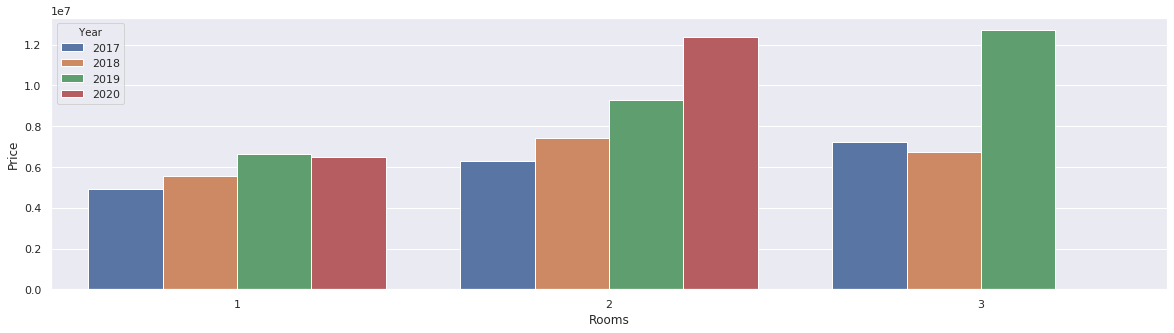

In [36]:
sns.barplot(x="Rooms", y="Price", hue="Year", data=df, estimator=np.mean, ci=None);

In [37]:
len(df[df['Rooms'] == 1])

218

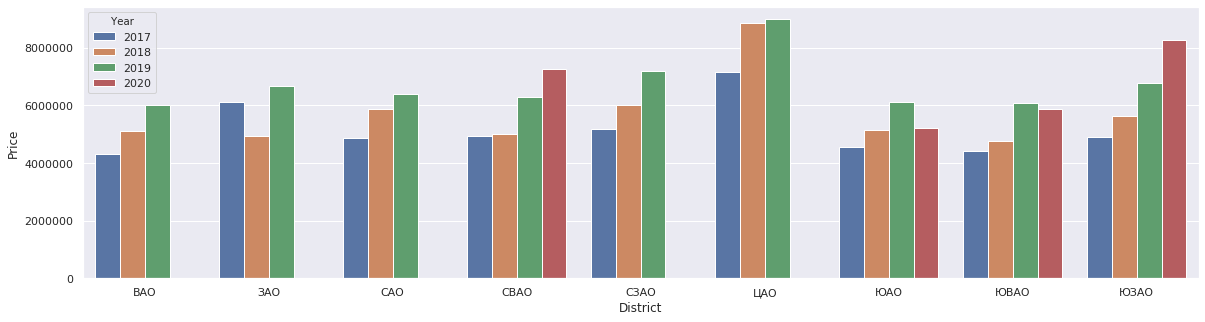

In [47]:
sns.barplot(x="District", y="Price", hue="Year", data=df[df['Rooms'] == 1], estimator=np.mean, ci=None, order=np.sort(df['District'].unique()) );

In [39]:
len(df[df['Rooms'] == 2])

159

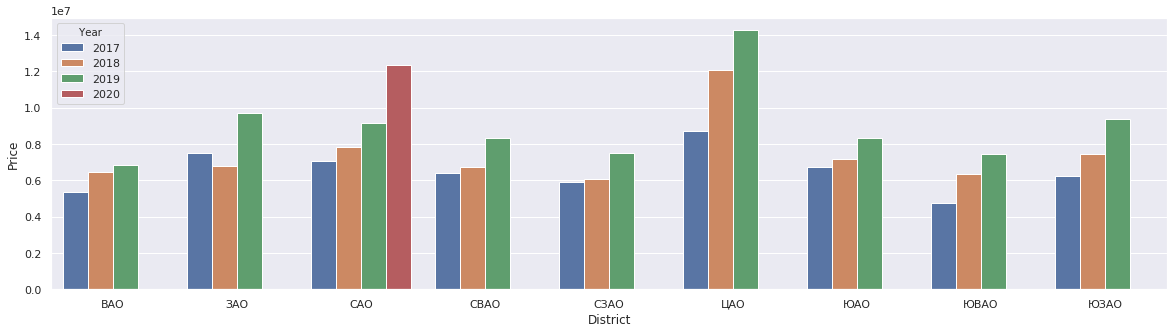

In [48]:
sns.barplot(x="District", y="Price", hue="Year", data=df[df['Rooms'] == 2], estimator=np.mean, ci=None, order=np.sort(df['District'].unique()) );

In [41]:
len(df[df['Rooms'] == 3])

20

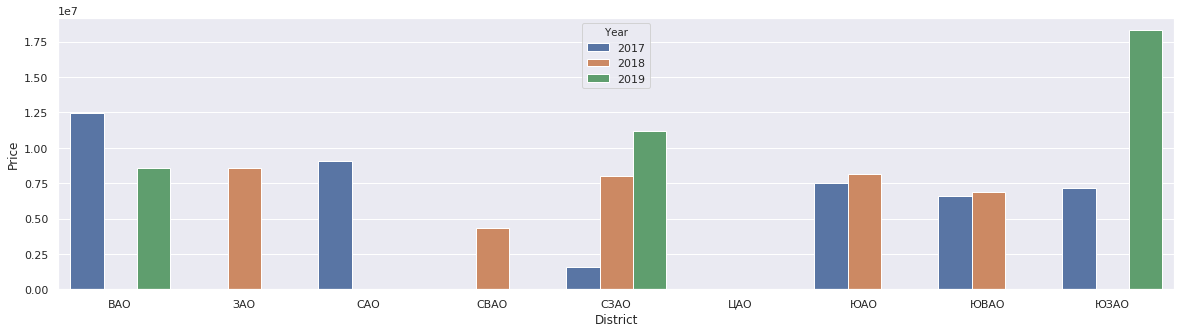

In [49]:
sns.barplot(x="District", y="Price", hue="Year", data=df[df['Rooms'] == 3], estimator=np.mean, ci=None, order=np.sort(df['District'].unique()) );